# 2PathsBiLSTM_CNN model

In this notebook we trained the 2PathsBiLSTM_CNN model using the training and validation set created during preprocessing.

By considering correlation analysis between features (preprocessing analysis), we noticed a strong correlation between the different channels. So, in this model we exploit the fact that two contiguous channels are highly correlated (x1, x2) (x3, x4) (x5, x6) (correlation greater than 90%).

So, this give us the idea to separate these channels into two "ways" and analyze them separately in two bilstm models. In the end, they are concatenated and analyzed together with a CNN + Dense neural network.

## Initialization

On Colab upload manually the file `dataset.zip`

In [ ]:
!unzip -o dataset.zip

Archive:  dataset.zip
  inflating: x_train.npy             
  inflating: y_train.npy             
  inflating: x_train_ov.npy          
  inflating: y_train_ov.npy          
  inflating: x_val.npy               
  inflating: y_val.npy               


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing as sklp
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 135 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 49.5 MB/s 


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset

In [ ]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1938, 36, 6), (491, 36, 6), (1938, 12), (491, 12))

## Model

In [ ]:
input_shape = x_train.shape[1:]
classes = 12
batch_size = 128
epochs = 200
input_shape, classes


((36, 6), 12)

### custom layer

### Definition

In [ ]:
def build_2paths_bilstm_cnn(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    c0 = tfkl.Lambda(lambda x : x[:,:,0])(input_layer)[...,np.newaxis]
    c1 = tfkl.Lambda(lambda x : x[:,:,1])(input_layer)[...,np.newaxis]
    c2 = tfkl.Lambda(lambda x : x[:,:,2])(input_layer)[...,np.newaxis]
    c3 = tfkl.Lambda(lambda x : x[:,:,3])(input_layer)[...,np.newaxis]
    c4 = tfkl.Lambda(lambda x : x[:,:,4])(input_layer)[...,np.newaxis]
    c5 = tfkl.Lambda(lambda x : x[:,:,5])(input_layer)[...,np.newaxis]

    

    #PATH1
    # Feature extractor
    path1 = tfkl.Concatenate()([c0,c2,c4])
    path1 = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(path1)
    # path1 = tfkl.Bidirectional(tfkl.LSTM(64))(path1)
    # Dense
    # path1 = tfkl.Dense(32, activation='relu')(path1)
    # path1 = tfkl.Dense(classes, activation='softmax')(path1)

    #PATH2
    # Feature extractor
    path2 = tfkl.Concatenate()([c1,c3,c5])
    path2 = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(path2)
    # path2 = tfkl.Bidirectional(tfkl.LSTM(64))(path2)
    # Dense
    # path2 = tfkl.Dense(32, activation='relu')(path2)
    # path2 = tfkl.Dense(classes, activation='softmax')(path2)

    #Merging
    merged = tfkl.Concatenate()([path1, path2])
    merged = tfkl.Conv1D(filters=256, kernel_size=3, padding="same")(merged)
    merged = tfkl.MaxPooling1D()(merged)
    merged = tfkl.Conv1D(128,3,padding='same',activation='relu')(merged)

    merged = tfkl.GlobalAveragePooling1D()(merged)
    merged = tfkl.Dropout(.3, seed=seed)(merged)

    merged = tfkl.Dense(64, activation='relu')(merged)
    output_layer = tfkl.Dense(classes, activation='softmax')(merged)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Return the model
    return model

### Build

In [ ]:
model = build_2paths_bilstm_cnn(input_shape, classes)

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 36)           0           ['Input[0][0]']                  
                                                                                                  
 lambda_2 (Lambda)              (None, 36)           0           ['Input[0][0]']                  
                                                                                                  
 lambda_4 (Lambda)              (None, 36)           0           ['Input[0][0]']                  
                                                                                              

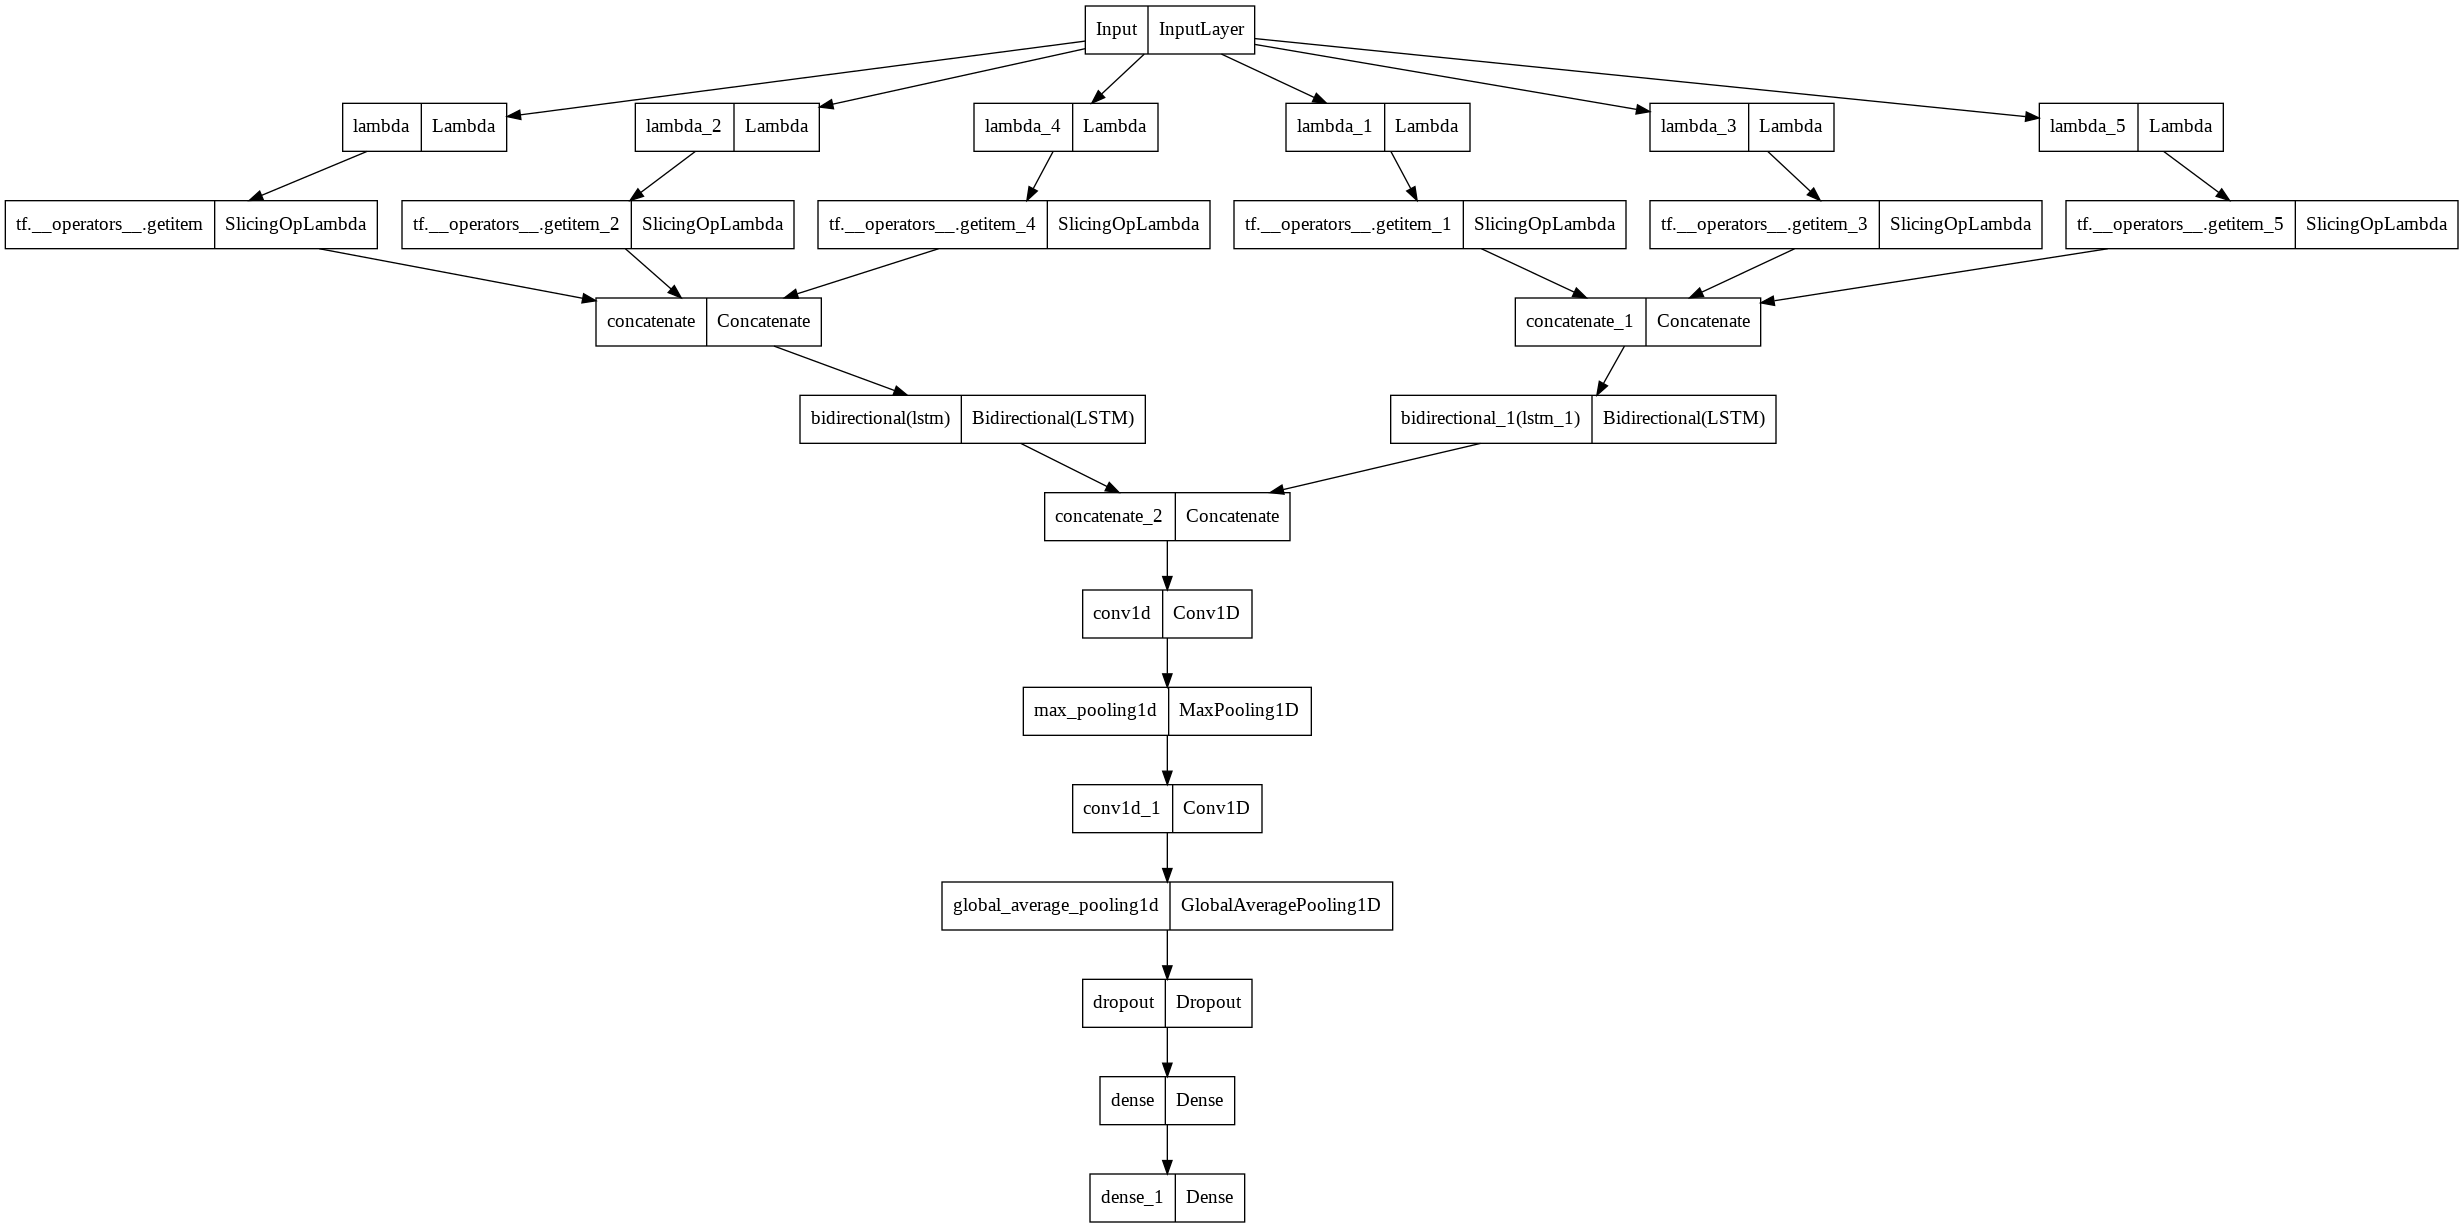

In [ ]:
tfk.utils.plot_model(model)

## Traininig

In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose = True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, mode='auto',verbose=1, factor=0.01, min_lr=1e-12)
    ]
).history

Epoch 1/200
16/16 [==============================] - 18s 147ms/step - loss: 1.8998 - accuracy: 0.3953 - val_loss: 1.5297 - val_accuracy: 0.4623 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 23ms/step - loss: 1.4889 - accuracy: 0.4974 - val_loss: 1.3314 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 22ms/step - loss: 1.2944 - accuracy: 0.5573 - val_loss: 1.2411 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 22ms/step - loss: 1.1625 - accuracy: 0.5934 - val_loss: 1.1568 - val_accuracy: 0.5906 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 22ms/step - loss: 1.0606 - accuracy: 0.6352 - val_loss: 1.0960 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 21ms/step - loss: 1.0143 - accuracy: 0.6481 - val_loss: 1.0353 - val_accuracy: 0.6436 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 21ms/step - 

### Results

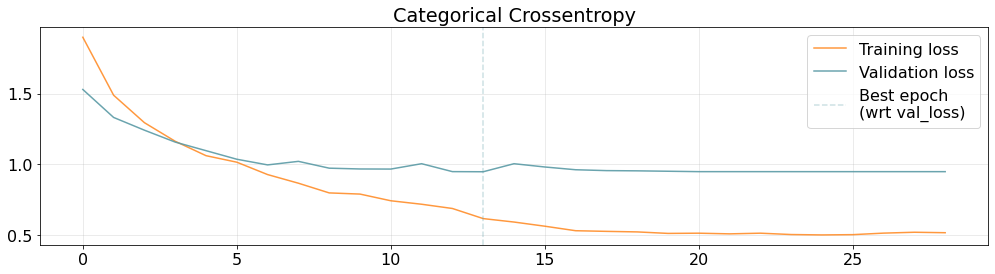

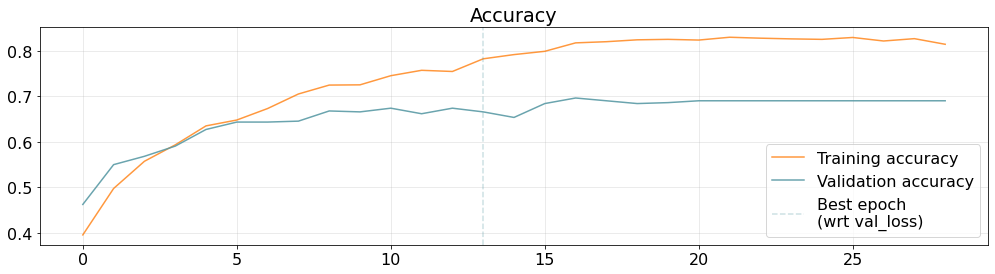

In [ ]:
##
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch\n(wrt val_loss)', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch\n(wrt val_loss)', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.predict(x_val)

16/16 [==============================] - 2s 17ms/step


(491, 12)

In [ ]:
target_categories = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine",
}

In [ ]:
def plot_confusion_matrix(cm, ds_type, labels = list(target_categories.values()) ):
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

Accuracy: 0.6965
Precision: 0.6288
Recall: 0.5538
F1: 0.5716


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


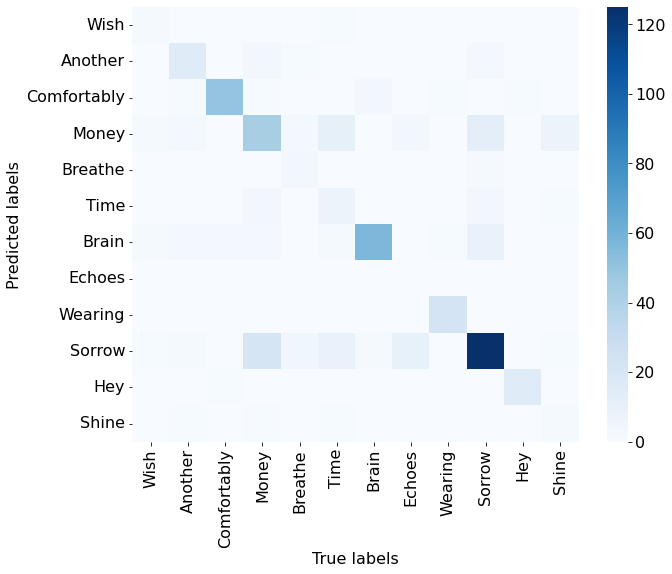

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(target_categories.values()), yticklabels=list(target_categories.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

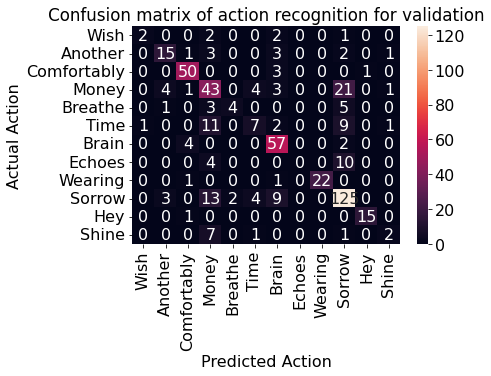

In [ ]:
plot_confusion_matrix(cm, 'validation')

### Save

In [ ]:
model.save("model")
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: model/variables/variables.index (deflated 71%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 93%)
